In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [ ]:
pip install torch torchvision matplotlib scikit-learn numpy

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install torchvision

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np

In [ ]:

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
data_dir = "/kaggle/input/chest-xray-pneumonia"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229])  # Grayscale normalization
])

In [ ]:
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229])
])


In [ ]:
data_dir = "/kaggle/input/chest-xray-pneumonia"  # Update this path
train_dir = os.path.join(data_dir, "chest_xray", "train")
val_dir = os.path.join(data_dir, "chest_xray", "val")
test_dir = os.path.join(data_dir, "chest_xray", "test")

# Define transforms for data augmentation and normalization
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229])  # Grayscale normalization
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229])
])

# Load datasets
train_dataset = ImageFolder(train_dir, transform=train_transforms)
val_dataset = ImageFolder(val_dir, transform=val_test_transforms)
test_dataset = ImageFolder(test_dir, transform=val_test_transforms)

In [ ]:

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")

Train samples: 5216, Val samples: 16, Test samples: 624
Classes: ['NORMAL', 'PNEUMONIA']


In [ ]:
model = torchvision.models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]


In [ ]:
class_counts = np.bincount([train_dataset.targets[i] for i in range(len(train_dataset))])
class_weights = torch.tensor([1.0 / class_counts[0], 1.0 / class_counts[1]], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)



In [ ]:

def train_model(model, train_loader, val_loader, optimizer, scheduler=None, num_epochs=10):
    train_losses, val_losses = [], []
    for epoch in range(num_epochs):

        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        if scheduler:
            scheduler.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_losses, val_losses

In [ ]:

def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)
    cm = confusion_matrix(all_labels, all_preds)

    return accuracy, f1, auc, cm

In [ ]:
def plot_loss_curves(train_losses, val_losses, title):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.savefig(f"{title.lower().replace(' ', '_')}.png")
    plt.show()

In [ ]:
print("Training with Adam...")
model_adam = torchvision.models.resnet18(pretrained=True)
model_adam.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
model_adam.fc = nn.Linear(num_ftrs, 2)
model_adam = model_adam.to(device)
optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.001, weight_decay=1e-4)


Training with Adam...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:

train_losses_adam, val_losses_adam = train_model(model_adam, train_loader, val_loader, optimizer_adam, num_epochs=10)

Epoch 1/10, Train Loss: 0.1944, Val Loss: 0.6099
Epoch 2/10, Train Loss: 0.1090, Val Loss: 0.8862
Epoch 3/10, Train Loss: 0.1025, Val Loss: 0.6213
Epoch 4/10, Train Loss: 0.1037, Val Loss: 0.1401
Epoch 5/10, Train Loss: 0.0966, Val Loss: 1.3601
Epoch 6/10, Train Loss: 0.0760, Val Loss: 0.3593
Epoch 7/10, Train Loss: 0.0773, Val Loss: 0.2564
Epoch 8/10, Train Loss: 0.0847, Val Loss: 0.5166
Epoch 9/10, Train Loss: 0.0718, Val Loss: 0.4604
Epoch 10/10, Train Loss: 0.0733, Val Loss: 0.4548


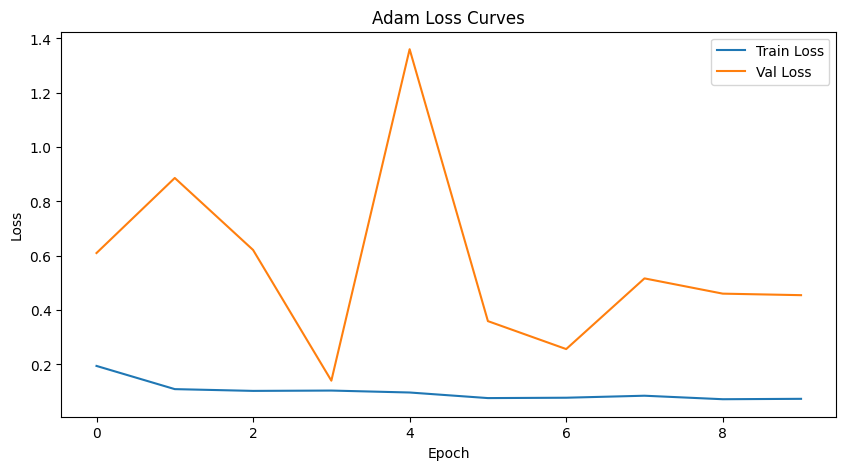

In [ ]:
plot_loss_curves(train_losses_adam, val_losses_adam, "Adam Loss Curves")
accuracy_adam, f1_adam, auc_adam, cm_adam = evaluate_model(model_adam, test_loader)

In [ ]:
print(f"Adam - Accuracy: {accuracy_adam:.4f}, F1-Score: {f1_adam:.4f}, AUC-ROC: {auc_adam:.4f}")
print(f"Adam - Confusion Matrix:\n{cm_adam}")

Adam - Accuracy: 0.8317, F1-Score: 0.8797, AUC-ROC: 0.9470
Adam - Confusion Matrix:
[[135  99]
 [  6 384]]


In [ ]:
print("\nTraining with SGD...")
model_sgd = torchvision.models.resnet18(pretrained=True)
model_sgd.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
model_sgd.fc = nn.Linear(num_ftrs, 2)
model_sgd = model_sgd.to(device)




Training with SGD...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler_sgd = optim.lr_scheduler.CosineAnnealingLR(optimizer_sgd, T_max=10)
train_losses_sgd, val_losses_sgd = train_model(model_sgd, train_loader, val_loader, optimizer_sgd, scheduler_sgd, num_epochs=10)


Epoch 1/10, Train Loss: 0.2441, Val Loss: 1.7585
Epoch 2/10, Train Loss: 0.0952, Val Loss: 1.0823
Epoch 3/10, Train Loss: 0.0985, Val Loss: 0.1934
Epoch 4/10, Train Loss: 0.0640, Val Loss: 0.1520
Epoch 5/10, Train Loss: 0.0546, Val Loss: 0.1243
Epoch 6/10, Train Loss: 0.0436, Val Loss: 0.0949
Epoch 7/10, Train Loss: 0.0307, Val Loss: 0.1247
Epoch 8/10, Train Loss: 0.0330, Val Loss: 0.1478
Epoch 9/10, Train Loss: 0.0291, Val Loss: 0.1800
Epoch 10/10, Train Loss: 0.0211, Val Loss: 0.1630


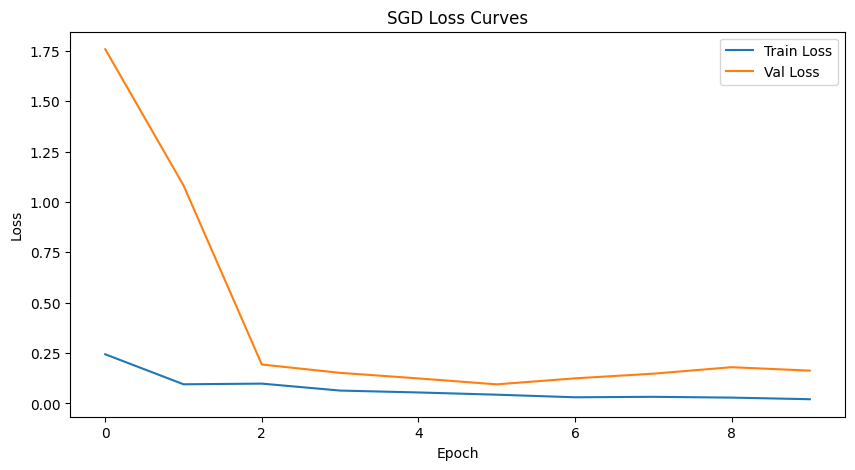

SGD - Accuracy: 0.8381, F1-Score: 0.8846, AUC-ROC: 0.9591
SGD - Confusion Matrix:
[[136  98]
 [  3 387]]


In [ ]:
plot_loss_curves(train_losses_sgd, val_losses_sgd, "SGD Loss Curves")
accuracy_sgd, f1_sgd, auc_sgd, cm_sgd = evaluate_model(model_sgd, test_loader)
print(f"SGD - Accuracy: {accuracy_sgd:.4f}, F1-Score: {f1_sgd:.4f}, AUC-ROC: {auc_sgd:.4f}")
print(f"SGD - Confusion Matrix:\n{cm_sgd}")

In [ ]:
print("\nSummary:")
print(f"Adam: Accuracy={accuracy_adam:.4f}, F1={f1_adam:.4f}, AUC={auc_adam:.4f}")
print(f"SGD: Accuracy={accuracy_sgd:.4f}, F1={f1_sgd:.4f}, AUC={auc_sgd:.4f}")


Summary:
Adam: Accuracy=0.8317, F1=0.8797, AUC=0.9470
SGD: Accuracy=0.8381, F1=0.8846, AUC=0.9591
